In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# loading dataset

In [2]:
df = pd.read_csv('../input/aeroplane-crash-data-from-1919-to-2025/cleaned_data.csv')

In [3]:
df.head()

,aircraft_type,registration,operator,fatalities,location,damage,Time,Flight #,Route,cn/In,...,crashes,serious_injuries,minor_injuries,incidents,date,year,month,day,hour,fatality_overcount
0,wright flyer iii,unknown,military - u.s. army,1.0,"fort myer, virginia",unknown,17:18,unknown,demonstration,1,...,0.0,0.0,0.0,0.0,1908-09-17,1908,9,17,17,False
1,dirigible,unknown,mililtary - u.s. navy,5.0,"atlanticity, new jersey",unknown,06:30,unknown,test flight,unknown,...,0.0,0.0,0.0,0.0,1912-07-12,1912,7,12,6,False
2,curtiss seaplane,unknown,private,1.0,"victoria, british columbia, canada",unknown,Unknown,-,unknown,unknown,...,0.0,0.0,0.0,0.0,1913-08-06,1913,8,6,-1,False
3,zeppelin l-1 (airship),unknown,military - german navy,14.0,over the north sea,unknown,18:30,unknown,unknown,unknown,...,0.0,0.0,0.0,0.0,1913-09-09,1913,9,9,18,False
4,zeppelin l-2 (airship),unknown,military - german navy,30.0,"near johannisthal, germany",unknown,10:30,unknown,unknown,unknown,...,0.0,0.0,0.0,0.0,1913-10-17,1913,10,17,10,False


In [4]:
df.isnull().sum()

aircraft_type         0
registration          0
operator              0
fatalities            0
location              0
damage                0
Time                  0
Flight #              0
Route                 0
cn/In                 0
Aboard                0
Ground                0
Summary               0
summary               0
crashes               0
serious_injuries      0
minor_injuries        0
incidents             0
date                  0
year                  0
month                 0
day                   0
hour                  0
fatality_overcount    0
dtype: int64

In [5]:
df.fatality_overcount.value_counts()

fatality_overcount
False    22055
True      8913
Name: count, dtype: int64

# data preprocessing

In [6]:
# renaming columns
df.rename(columns={'Summary': 'summ1', 'summary': 'summ2'}, inplace=True)
df.rename(columns={'flight #': 'flight_num'}, inplace=True)

In [7]:
# converting columns to lowercase
df.columns = df.columns.str.lower()

In [8]:
# converting data type from float to int
df.aboard = df.aboard.astype(int)
df.fatalities = df.fatalities.astype(int)
df.crashes = df.crashes.astype(int)
df.serious_injuries = df.serious_injuries.astype(int)
df.minor_injuries = df.minor_injuries.astype(int)
df.incidents = df.incidents.astype(int)

In [9]:
df.shape

(30968, 24)

In [10]:
# taking last 2 decade data
df = df[(df['year'] >= 2000) & (df['year'] <= 2025)]

In [11]:
df.shape

(7285, 24)

In [12]:
# reset index to date (datetime)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace = True)
df.head(2)

,aircraft_type,registration,operator,fatalities,location,damage,time,flight #,route,cn/in,...,summ2,crashes,serious_injuries,minor_injuries,incidents,year,month,day,hour,fatality_overcount
date,,,,,,,,,,,,,,,,,,,,,
2000-01-01,unknown,unknown,unknown,1586,unknown,unknown,Unknown,unknown,unknown,unknown,...,No summary available,0,0,0,198,2000,1,1,-1,True
2000-01-01,cessna 550 citation ii,n752cc,us customs service,0,"homestead, florida",sub,Unknown,unknown,unknown,unknown,...,No summary available,0,0,0,0,2000,1,1,-1,False


In [13]:
print(df[df.summ1 == 'No summary available'].value_counts().sum()) # 240 valid

print(df[df.summ2 == 'No summary available'].value_counts().sum()) # 6 valid

print(df[(df.summ2 == 'No summary available') & (df.summ1 == 'No summary available')].value_counts().sum()) # 246

6704
7276
6695


In [14]:
5463-5229

234

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7285 entries, 2000-01-01 to 2025-11-14
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   aircraft_type       7285 non-null   object 
 1   registration        7285 non-null   object 
 2   operator            7285 non-null   object 
 3   fatalities          7285 non-null   int64  
 4   location            7285 non-null   object 
 5   damage              7285 non-null   object 
 6   time                7285 non-null   object 
 7   flight #            7285 non-null   object 
 8   route               7285 non-null   object 
 9   cn/in               7285 non-null   object 
 10  aboard              7285 non-null   int64  
 11  ground              7285 non-null   float64
 12  summ1               7285 non-null   object 
 13  summ2               7285 non-null   object 
 14  crashes             7285 non-null   int64  
 15  serious_injuries    7285 non-null   i

In [16]:
# number of unique aircraft type
len(df['aircraft_type'].unique())

2019

In [17]:
df[df['crashes']==0].value_counts().sum()

7265

In [18]:
# df['year'].value_counts() # unsorted
# df['year'].value_counts().sort_index() # sorted index : HERE index = year

In [19]:
# # crashes by year
# plt.figure(figsize=(10,5))
# df['year'].value_counts().sort_index().plot(rot=90, kind='bar') # or df.groupby('year').size().plot(kind='bar', rot=90)
# plt.xlabel('Year')
# plt.ylabel('Count')
# plt.title('Crash counts per Year')
# plt.show()

# plotting and visualization

## crash counts by year, month, day

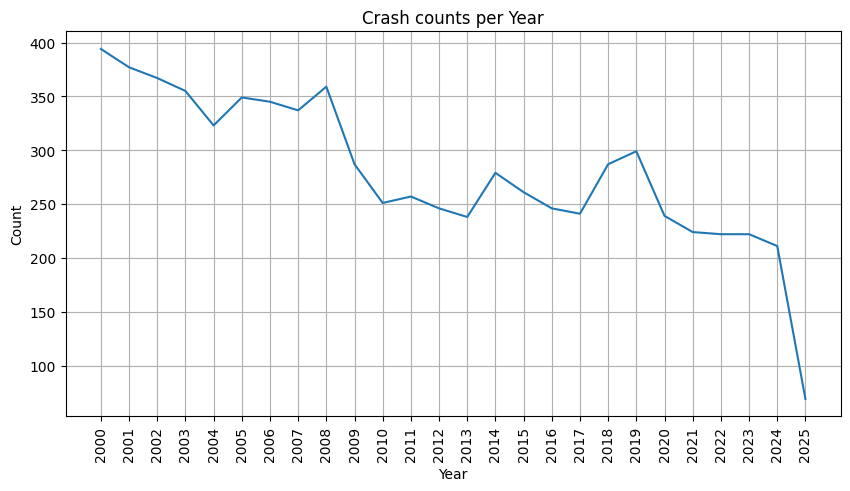

In [20]:
# no. of crashes happended per year
plt.figure(figsize=(10,5))
df['year'].value_counts().sort_index().plot(rot=90, kind='line').set_xticks(df['year'].value_counts().sort_index().index)
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Crash counts per Year')
plt.grid(True)
plt.show()

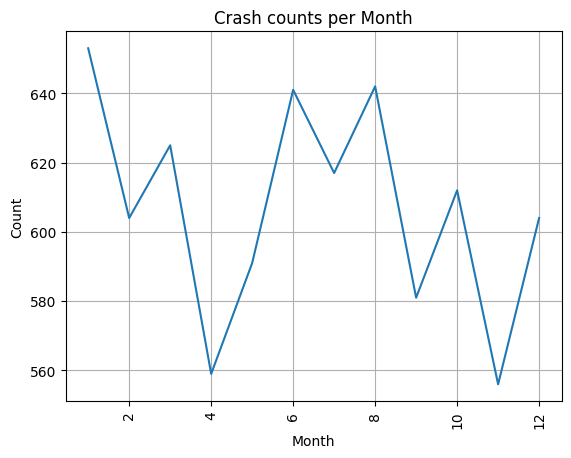

In [21]:
# no. of crashes happended per month
df['month'].value_counts().sort_index().plot(rot=90, kind='line') 
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Crash counts per Month')
plt.grid(True)
plt.show()

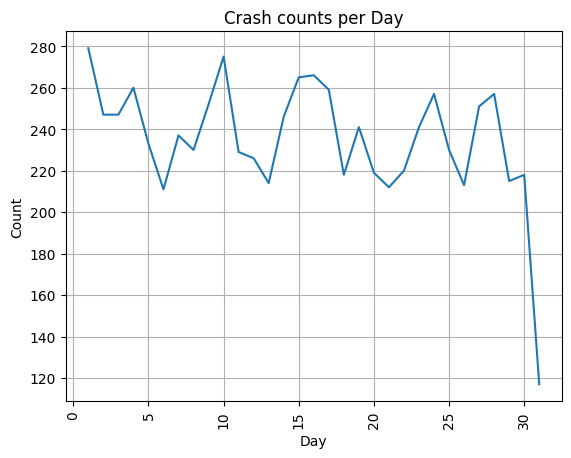

In [22]:
# no. of crashes happended per day
df['day'].value_counts().sort_index().plot(rot=90, kind='line') 
plt.xlabel('Day')
plt.ylabel('Count')
plt.title('Crash counts per Day')
plt.grid(True)
plt.show()

## incidents counts by year, month, day

In [23]:
# # below plot is useful only if each row represents a unique event and you're interested in seeing their exact individual values.
# plt.figure(figsize=(9,4))
# plt.plot(df.year, df.incidents, color='green', marker='.', linestyle='dashed', linewidth=2, markersize=12)
# plt.ylabel('Count')
# plt.title('Crash counts per Year')
# plt.grid(True)
# plt.show()

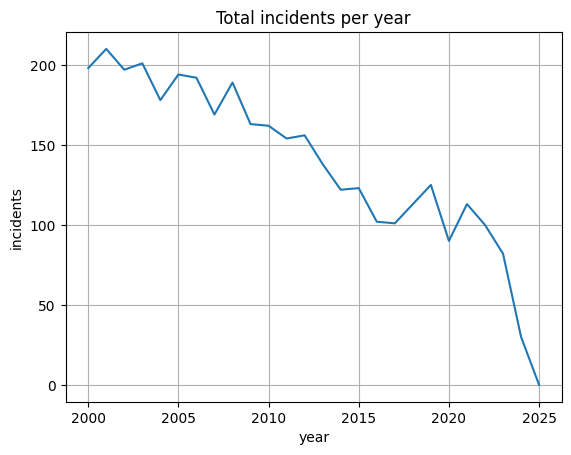

In [24]:
# total incidents by year
ax = sn.lineplot(data=df.groupby('year')[['incidents']].sum().reset_index(), x='year', y='incidents')
ax.set_xticklabels([int(tick) for tick in ax.get_xticks()])
plt.title('Total incidents per year')
plt.grid(True)
plt.show()

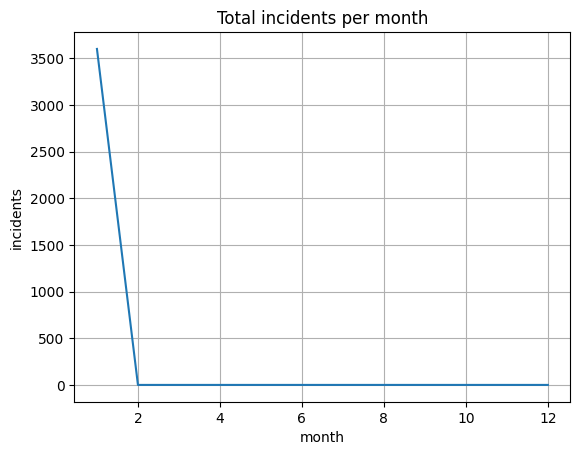

In [25]:
# total incidents by month
ax = sn.lineplot(data=df.groupby('month')[['incidents']].sum().reset_index(), x='month', y='incidents')
plt.title('Total incidents per month')
plt.grid(True)
plt.show()

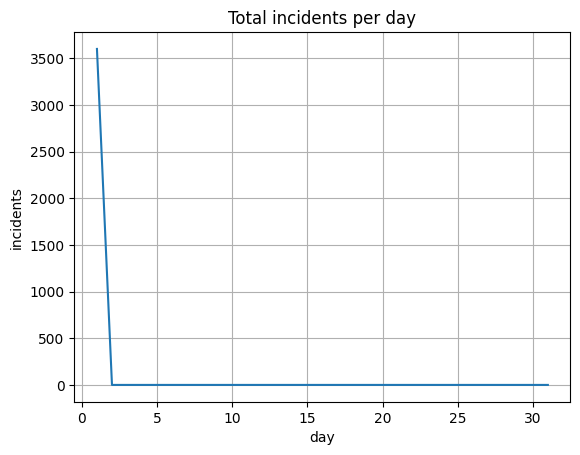

In [26]:
# total incidents by day
ax = sn.lineplot(data=df.groupby('day')[['incidents']].sum().reset_index(), x='day', y='incidents')
plt.title('Total incidents per day')
plt.grid(True)
plt.show()

## fatalities counts by year, month, day

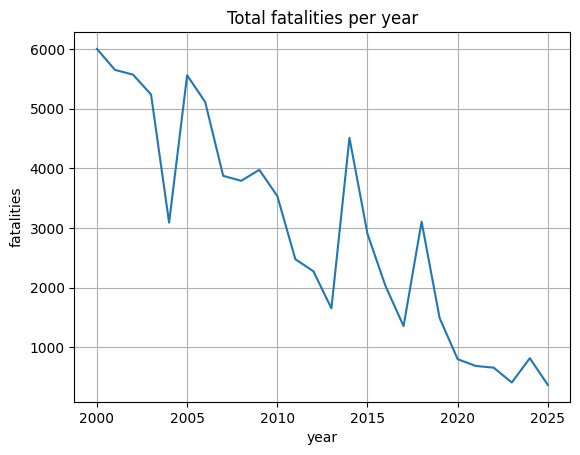

In [27]:
# total incidents by year
ax = sn.lineplot(data=df.groupby('year')[['fatalities']].sum().reset_index(), x='year', y='fatalities')
ax.set_xticklabels([int(tick) for tick in ax.get_xticks()])
plt.title('Total fatalities per year')
plt.grid(True)
plt.show()

> downward trend, multiplicative -> fatilities by year
> 
> downward trend, add -> incidents by year

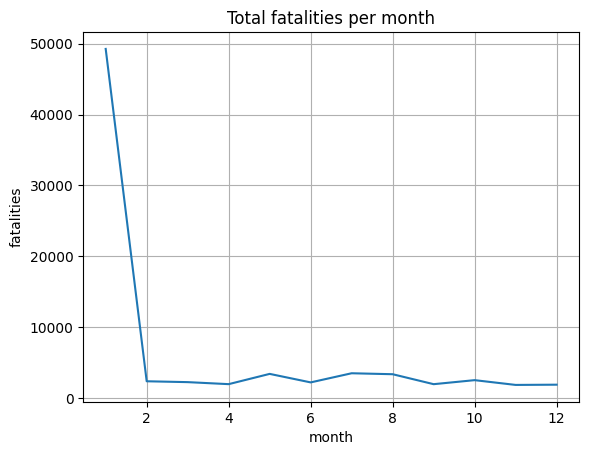

In [28]:
# total fatalities by month
ax = sn.lineplot(data=df.groupby('month')[['fatalities']].sum().reset_index(), x='month', y='fatalities')
plt.title('Total fatalities per month')
plt.grid(True)
plt.show()

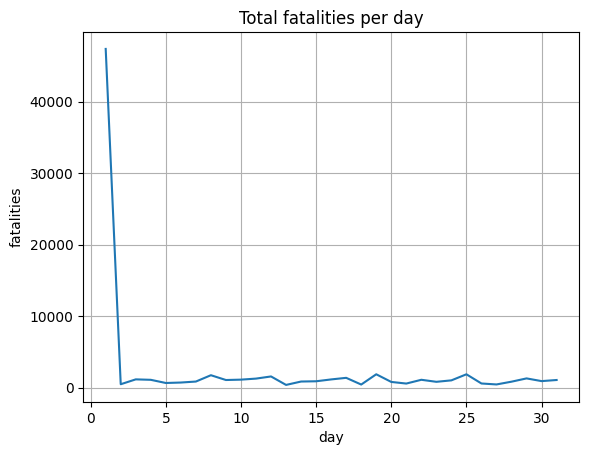

In [29]:
# total fatalities by day
ax = sn.lineplot(data=df.groupby('day')[['fatalities']].sum().reset_index(), x='day', y='fatalities')
plt.title('Total fatalities per day')
plt.grid(True)
plt.show()

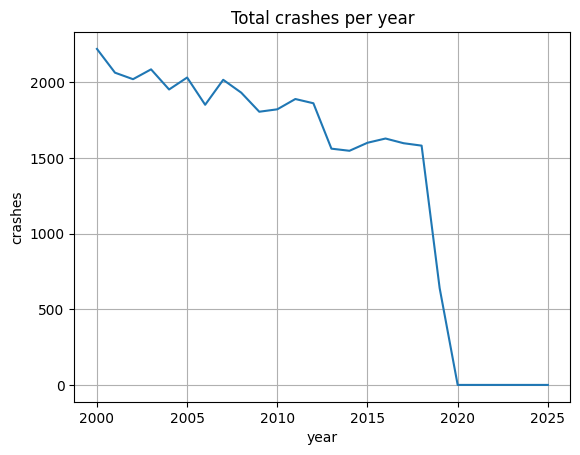

In [30]:
# total no. of crashes reported per  year
ax = sn.lineplot(data=df.groupby('year')[['crashes']].sum().reset_index(), x='year', y='crashes')
ax.set_xticklabels([int(tick) for tick in ax.get_xticks()])
plt.title('Total crashes per year')
plt.grid(True)
plt.show()

# seasonal decomposition